**New York University** \\
**ECE GY- 7123 Deep Learning - Mini Project** \\
ResNet \\
By Amaan Ansari - ama10595, Amaan Mithani am14647, Kunaal Vadgama kv2343


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary
from torchvision.utils import make_grid
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Define transforms for training data and testing data
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
																                transforms.ToTensor(),
																								        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [ ]:
# Import train and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170M/170M [00:05<00:00, 29.5MB/s]


In [ ]:
# Define classes for train dataset
classes = trainset.class_to_idx

In [ ]:
# Define the batch size
batch = 128

In [ ]:
# Define data loaders for train and test data
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


<ipython-input-8-9395ea726562>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stdDev = torch.tensor(means).reshape(1,3,1,1)


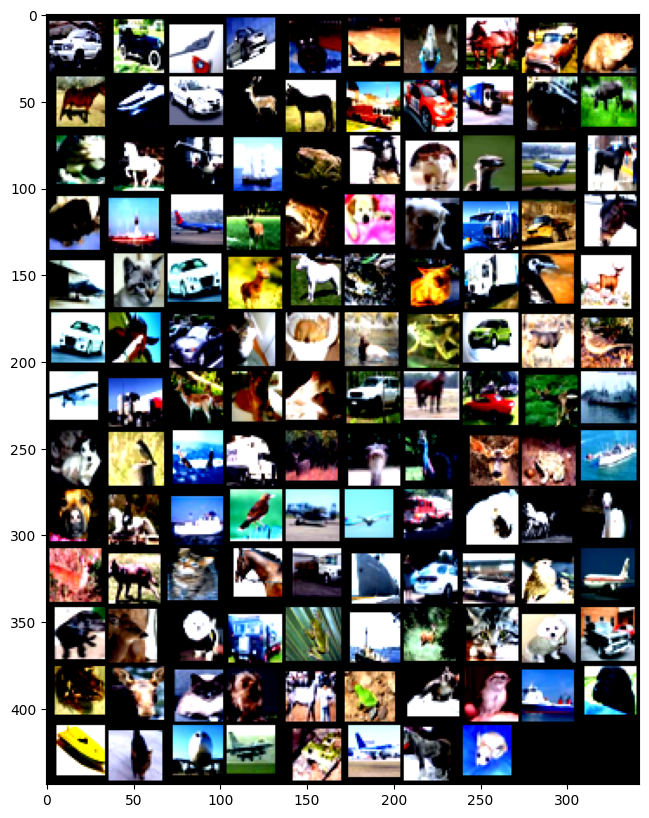

In [ ]:
# Preview the data for reference

# Define data dimension
data_stats = [(0.5,0.5,0.5),(0.5,0.5,0.5)]

# Function to denormalize data
def denormalize(images,means,stdDev):
  means = torch.tensor(means).reshape(1,3,1,1)
  stdDev = torch.tensor(means).reshape(1,3,1,1)
  return(images*stdDev+means)

# Function to show data
def showPreview(dataimglab):
  for images,labels in dataimglab:
    fig,ax = plt.subplots(figsize=(10,10))
    ax.imshow(make_grid(denormalize(images,*data_stats),10).permute(1,2,0))
    break

# Preview data
showPreview(train_loader)

In [ ]:
# Defining basic neural network block
class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, stride=1, dropout =0.1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.dropout = nn.Dropout(p = dropout)
    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != planes:
      self.shortcut = nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(planes))

  def forward(self, x):
    out = self.dropout(F.relu(self.bn1(self.conv1(x))))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

In [ ]:
# Defining Resnet architecture with the most effecient parameters
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10, dropout =0.1):
    super(ResNet, self).__init__()
    self.in_planes = 32
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3,stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(32)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.linear2 = nn.Linear(256, 128)
    self.linear = nn.Linear(128, num_classes)
    self.dropout = nn.Dropout(p = dropout)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.dropout(F.relu(self.bn1(self.conv1(x))))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = F.avg_pool2d(out, 6)
    out = out.view(out.size(0), -1)
    out = self.linear2(out)
    out = self.linear(out)
    return out

In [ ]:
# Defining the loss and accuracy variables
train_acc = []
test_acc_l1 = []
train_losses = []
test_losses_l1 = []
epoch_train_losses = []

In [ ]:
# Function to train the model
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar=tqdm(train_loader)
  correct = 0
  processed = 0
  epoch_loss = 0
  criterion= nn.CrossEntropyLoss().to(device)

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss  = criterion(y_pred, target)
    epoch_loss += loss
    train_losses.append(loss)
    loss.backward()
    optimizer.step()

    # get the index of the max log-probability
    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  return epoch_loss/len(train_loader.dataset), train_acc

In [ ]:
# Function to test the model
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  criterion= nn.CrossEntropyLoss().to(device)

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses_l1.append(test_loss)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
                                                                               100. * correct / len(test_loader.dataset)))
  test_acc_l1.append(100. * correct / len(test_loader.dataset))

In [ ]:
# Set cuda as device for faster processing
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# Create the Restnet model
model = ResNet(BasicBlock, [2,2,2,2]).to(device)
model

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (shortcut): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(

In [ ]:
# Check the number of parameters
param_check = sum(p.numel() for p in model.parameters() if p.requires_grad)
param_check

2792106

In [ ]:
# Check the number of parameters using torchsummary.summary function
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
           Dropout-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
           Dropout-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
          Dropout-14           [-1, 64,

The number of trainable parameters used by our model is 2,792,106.
We were successfully able to reduce the numbr of parameters by modifying the traditional ResNet architecture.

In [ ]:
# Initialize the number of epochs, learning Rate, and momentum
epochs = 150
LR = 0.001  # Start with a slightly higher learning rate
moment = 0.9  # Slightly higher momentum for stability over longer training



In [ ]:
# Train the model
arr_train1 =[]
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=moment)
scheduler = OneCycleLR(optimizer,max_lr=0.1,total_steps= None,epochs=epochs,steps_per_epoch=len(train_loader))

for epoch in range(epochs):
  print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
  train_epoch_loss, train_epoch_accuracy = train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)
  epoch_train_losses.append(train_epoch_loss)
  scheduler.step()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:2147: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: 0 Learning_Rate [0.0040000000000000036]


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loss=1.2615468502044678 Batch_id=390 Accuracy=41.42: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]



Test set: Average loss: 0.0117, Accuracy: 4908/10000 (49.0800%)

Epoch: 1 Learning_Rate [0.004000000765212064]


Loss=0.9230817556381226 Batch_id=390 Accuracy=62.44: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s]



Test set: Average loss: 0.0082, Accuracy: 6473/10000 (64.7300%)

Epoch: 2 Learning_Rate [0.004000003060848245]


Loss=0.9171645045280457 Batch_id=390 Accuracy=70.65: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]



Test set: Average loss: 0.0060, Accuracy: 7400/10000 (74.0000%)

Epoch: 3 Learning_Rate [0.004000006886908478]


Loss=0.677033543586731 Batch_id=390 Accuracy=75.85: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]



Test set: Average loss: 0.0056, Accuracy: 7625/10000 (76.2500%)

Epoch: 4 Learning_Rate [0.004000012243392609]


Loss=0.49236732721328735 Batch_id=390 Accuracy=78.92: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s]



Test set: Average loss: 0.0052, Accuracy: 7892/10000 (78.9200%)

Epoch: 5 Learning_Rate [0.004000019130300486]


Loss=0.5364606380462646 Batch_id=390 Accuracy=81.08: 100%|██████████| 391/391 [00:34<00:00, 11.39it/s]



Test set: Average loss: 0.0048, Accuracy: 7971/10000 (79.7100%)

Epoch: 6 Learning_Rate [0.0040000275476318875]


Loss=0.4170975685119629 Batch_id=390 Accuracy=82.81: 100%|██████████| 391/391 [00:34<00:00, 11.37it/s]



Test set: Average loss: 0.0044, Accuracy: 8170/10000 (81.7000%)

Epoch: 7 Learning_Rate [0.004000037495386563]


Loss=0.40694093704223633 Batch_id=390 Accuracy=84.07: 100%|██████████| 391/391 [00:34<00:00, 11.37it/s]



Test set: Average loss: 0.0046, Accuracy: 8092/10000 (80.9200%)

Epoch: 8 Learning_Rate [0.00400004897356418]


Loss=0.3437293767929077 Batch_id=390 Accuracy=85.30: 100%|██████████| 391/391 [00:34<00:00, 11.33it/s]



Test set: Average loss: 0.0045, Accuracy: 8193/10000 (81.9300%)

Epoch: 9 Learning_Rate [0.004000061982164349]


Loss=0.3546285331249237 Batch_id=390 Accuracy=86.19: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.0037, Accuracy: 8478/10000 (84.7800%)

Epoch: 10 Learning_Rate [0.004000076521186696]


Loss=0.33580201864242554 Batch_id=390 Accuracy=86.95: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0036, Accuracy: 8522/10000 (85.2200%)

Epoch: 11 Learning_Rate [0.0040000925906307355]


Loss=0.431659072637558 Batch_id=390 Accuracy=87.64: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 0.0033, Accuracy: 8606/10000 (86.0600%)

Epoch: 12 Learning_Rate [0.0040001101904959535]


Loss=0.1880512535572052 Batch_id=390 Accuracy=88.42: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0031, Accuracy: 8709/10000 (87.0900%)

Epoch: 13 Learning_Rate [0.004000129320781795]


Loss=0.22920429706573486 Batch_id=390 Accuracy=88.81: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]



Test set: Average loss: 0.0036, Accuracy: 8527/10000 (85.2700%)

Epoch: 14 Learning_Rate [0.004000149981487663]


Loss=0.3416508734226227 Batch_id=390 Accuracy=89.69: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s]



Test set: Average loss: 0.0033, Accuracy: 8651/10000 (86.5100%)

Epoch: 15 Learning_Rate [0.004000172172612879]


Loss=0.28734180331230164 Batch_id=390 Accuracy=90.34: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s]



Test set: Average loss: 0.0036, Accuracy: 8594/10000 (85.9400%)

Epoch: 16 Learning_Rate [0.004000195894156733]


Loss=0.222742959856987 Batch_id=390 Accuracy=90.50: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.0031, Accuracy: 8771/10000 (87.7100%)

Epoch: 17 Learning_Rate [0.0040002211461184906]


Loss=0.24707186222076416 Batch_id=390 Accuracy=91.00: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.0033, Accuracy: 8746/10000 (87.4600%)

Epoch: 18 Learning_Rate [0.004000247928497319]


Loss=0.30621734261512756 Batch_id=390 Accuracy=91.51: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 0.0031, Accuracy: 8817/10000 (88.1700%)

Epoch: 19 Learning_Rate [0.0040002762412924]


Loss=0.3066500723361969 Batch_id=390 Accuracy=91.82: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.0028, Accuracy: 8926/10000 (89.2600%)

Epoch: 20 Learning_Rate [0.004000306084502775]


Loss=0.1966942548751831 Batch_id=390 Accuracy=92.17: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 0.0029, Accuracy: 8864/10000 (88.6400%)

Epoch: 21 Learning_Rate [0.004000337458127556]


Loss=0.27106478810310364 Batch_id=390 Accuracy=92.72: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s]



Test set: Average loss: 0.0030, Accuracy: 8859/10000 (88.5900%)

Epoch: 22 Learning_Rate [0.004000370362165703]


Loss=0.14565584063529968 Batch_id=390 Accuracy=92.81: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0029, Accuracy: 8901/10000 (89.0100%)

Epoch: 23 Learning_Rate [0.004000404796616175]


Loss=0.12574109435081482 Batch_id=390 Accuracy=93.19: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.0033, Accuracy: 8737/10000 (87.3700%)

Epoch: 24 Learning_Rate [0.004000440761477889]


Loss=0.13919425010681152 Batch_id=390 Accuracy=93.44: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s]



Test set: Average loss: 0.0027, Accuracy: 8926/10000 (89.2600%)

Epoch: 25 Learning_Rate [0.004000478256749679]


Loss=0.2409682720899582 Batch_id=390 Accuracy=93.83: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0031, Accuracy: 8915/10000 (89.1500%)

Epoch: 26 Learning_Rate [0.004000517282430352]


Loss=0.17084580659866333 Batch_id=390 Accuracy=93.96: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.0027, Accuracy: 8998/10000 (89.9800%)

Epoch: 27 Learning_Rate [0.004000557838518673]


Loss=0.18105602264404297 Batch_id=390 Accuracy=94.56: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s]



Test set: Average loss: 0.0028, Accuracy: 8978/10000 (89.7800%)

Epoch: 28 Learning_Rate [0.004000599925013351]


Loss=0.1432274580001831 Batch_id=390 Accuracy=94.64: 100%|██████████| 391/391 [00:34<00:00, 11.30it/s]



Test set: Average loss: 0.0029, Accuracy: 8989/10000 (89.8900%)

Epoch: 29 Learning_Rate [0.0040006435419130265]


Loss=0.23618510365486145 Batch_id=390 Accuracy=94.59: 100%|██████████| 391/391 [00:34<00:00, 11.35it/s]



Test set: Average loss: 0.0029, Accuracy: 9024/10000 (90.2400%)

Epoch: 30 Learning_Rate [0.004000688689216339]


Loss=0.06463440507650375 Batch_id=390 Accuracy=94.92: 100%|██████████| 391/391 [00:34<00:00, 11.33it/s]



Test set: Average loss: 0.0030, Accuracy: 9015/10000 (90.1500%)

Epoch: 31 Learning_Rate [0.004000735366921818]


Loss=0.10854335874319077 Batch_id=390 Accuracy=94.92: 100%|██████████| 391/391 [00:34<00:00, 11.30it/s]



Test set: Average loss: 0.0028, Accuracy: 9022/10000 (90.2200%)

Epoch: 32 Learning_Rate [0.0040007835750279774]


Loss=0.09613854438066483 Batch_id=390 Accuracy=95.53: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s]



Test set: Average loss: 0.0029, Accuracy: 9014/10000 (90.1400%)

Epoch: 33 Learning_Rate [0.004000833313533292]


Loss=0.12632644176483154 Batch_id=390 Accuracy=95.57: 100%|██████████| 391/391 [00:34<00:00, 11.35it/s]



Test set: Average loss: 0.0030, Accuracy: 8996/10000 (89.9600%)

Epoch: 34 Learning_Rate [0.004000884582436193]


Loss=0.06898802518844604 Batch_id=390 Accuracy=95.76: 100%|██████████| 391/391 [00:34<00:00, 11.32it/s]



Test set: Average loss: 0.0028, Accuracy: 9056/10000 (90.5600%)

Epoch: 35 Learning_Rate [0.004000937381735015]


Loss=0.11478313058614731 Batch_id=390 Accuracy=95.68: 100%|██████████| 391/391 [00:34<00:00, 11.33it/s]



Test set: Average loss: 0.0029, Accuracy: 9018/10000 (90.1800%)

Epoch: 36 Learning_Rate [0.0040009917114280785]


Loss=0.21627867221832275 Batch_id=390 Accuracy=96.02: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s]



Test set: Average loss: 0.0031, Accuracy: 9013/10000 (90.1300%)

Epoch: 37 Learning_Rate [0.0040010475715136495]


Loss=0.23074445128440857 Batch_id=390 Accuracy=96.13: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.0031, Accuracy: 9051/10000 (90.5100%)

Epoch: 38 Learning_Rate [0.004001104961989979]


Loss=0.16145044565200806 Batch_id=390 Accuracy=96.30: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]



Test set: Average loss: 0.0028, Accuracy: 9082/10000 (90.8200%)

Epoch: 39 Learning_Rate [0.004001163882855208]


Loss=0.06576427817344666 Batch_id=390 Accuracy=96.55: 100%|██████████| 391/391 [00:34<00:00, 11.30it/s]



Test set: Average loss: 0.0032, Accuracy: 9048/10000 (90.4800%)

Epoch: 40 Learning_Rate [0.004001224334107462]


Loss=0.09194181859493256 Batch_id=390 Accuracy=96.65: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s]



Test set: Average loss: 0.0031, Accuracy: 9034/10000 (90.3400%)

Epoch: 41 Learning_Rate [0.004001286315744812]


Loss=0.178760826587677 Batch_id=390 Accuracy=96.54: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.0033, Accuracy: 9023/10000 (90.2300%)

Epoch: 42 Learning_Rate [0.004001349827765302]


Loss=0.2015753537416458 Batch_id=390 Accuracy=96.67: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 0.0030, Accuracy: 9053/10000 (90.5300%)

Epoch: 43 Learning_Rate [0.004001414870166864]


Loss=0.13757936656475067 Batch_id=390 Accuracy=96.80: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 0.0029, Accuracy: 9129/10000 (91.2900%)

Epoch: 44 Learning_Rate [0.0040014814429474715]


Loss=0.06687774509191513 Batch_id=390 Accuracy=97.01: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 0.0028, Accuracy: 9140/10000 (91.4000%)

Epoch: 45 Learning_Rate [0.004001549546104974]


Loss=0.07449211925268173 Batch_id=390 Accuracy=97.16: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.0034, Accuracy: 9035/10000 (90.3500%)

Epoch: 46 Learning_Rate [0.004001619179637206]


Loss=0.12092223018407822 Batch_id=390 Accuracy=97.24: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.0032, Accuracy: 9088/10000 (90.8800%)

Epoch: 47 Learning_Rate [0.004001690343541947]


Loss=0.03594870865345001 Batch_id=390 Accuracy=97.19: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 0.0032, Accuracy: 9098/10000 (90.9800%)

Epoch: 48 Learning_Rate [0.004001763037816949]


Loss=0.06267403811216354 Batch_id=390 Accuracy=97.36: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.0032, Accuracy: 9067/10000 (90.6700%)

Epoch: 49 Learning_Rate [0.004001837262459854]


Loss=0.03415825963020325 Batch_id=390 Accuracy=97.51: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s]



Test set: Average loss: 0.0032, Accuracy: 9077/10000 (90.7700%)

Epoch: 50 Learning_Rate [0.004001913017468328]


Loss=0.032928530126810074 Batch_id=390 Accuracy=97.65: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.0030, Accuracy: 9137/10000 (91.3700%)

Epoch: 51 Learning_Rate [0.004001990302839931]


Loss=0.14053961634635925 Batch_id=390 Accuracy=97.61: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0031, Accuracy: 9145/10000 (91.4500%)

Epoch: 52 Learning_Rate [0.004002069118572232]


Loss=0.09975893795490265 Batch_id=390 Accuracy=97.75: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.0030, Accuracy: 9142/10000 (91.4200%)

Epoch: 53 Learning_Rate [0.004002149464662666]


Loss=0.13295313715934753 Batch_id=390 Accuracy=97.76: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0032, Accuracy: 9129/10000 (91.2900%)

Epoch: 54 Learning_Rate [0.0040022313411087335]


Loss=0.05758742243051529 Batch_id=390 Accuracy=97.87: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0031, Accuracy: 9146/10000 (91.4600%)

Epoch: 55 Learning_Rate [0.00400231474790777]


Loss=0.014879880473017693 Batch_id=390 Accuracy=97.99: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s]



Test set: Average loss: 0.0032, Accuracy: 9119/10000 (91.1900%)

Epoch: 56 Learning_Rate [0.004002399685057154]


Loss=0.14049431681632996 Batch_id=390 Accuracy=97.92: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]



Test set: Average loss: 0.0031, Accuracy: 9170/10000 (91.7000%)

Epoch: 57 Learning_Rate [0.004002486152554163]


Loss=0.05088990181684494 Batch_id=390 Accuracy=97.90: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 0.0034, Accuracy: 9088/10000 (90.8800%)

Epoch: 58 Learning_Rate [0.004002574150396038]


Loss=0.1004195362329483 Batch_id=390 Accuracy=98.06: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0033, Accuracy: 9121/10000 (91.2100%)

Epoch: 59 Learning_Rate [0.004002663678579987]


Loss=0.052852243185043335 Batch_id=390 Accuracy=98.20: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]



Test set: Average loss: 0.0037, Accuracy: 9127/10000 (91.2700%)

Epoch: 60 Learning_Rate [0.004002754737103126]


Loss=0.06712677329778671 Batch_id=390 Accuracy=98.13: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.0031, Accuracy: 9161/10000 (91.6100%)

Epoch: 61 Learning_Rate [0.00400284732596258]


Loss=0.049658387899398804 Batch_id=390 Accuracy=98.14: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s]



Test set: Average loss: 0.0032, Accuracy: 9157/10000 (91.5700%)

Epoch: 62 Learning_Rate [0.004002941445155381]


Loss=0.03796085715293884 Batch_id=390 Accuracy=98.22: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.0032, Accuracy: 9152/10000 (91.5200%)

Epoch: 63 Learning_Rate [0.00400303709467853]


Loss=0.027087533846497536 Batch_id=390 Accuracy=98.30: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0031, Accuracy: 9149/10000 (91.4900%)

Epoch: 64 Learning_Rate [0.004003134274529002]


Loss=0.023991268128156662 Batch_id=390 Accuracy=98.52: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.0033, Accuracy: 9138/10000 (91.3800%)

Epoch: 65 Learning_Rate [0.004003232984703647]


Loss=0.10803751647472382 Batch_id=390 Accuracy=98.38: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s]



Test set: Average loss: 0.0035, Accuracy: 9118/10000 (91.1800%)

Epoch: 66 Learning_Rate [0.004003333225199371]


Loss=0.06624434888362885 Batch_id=390 Accuracy=98.40: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s]



Test set: Average loss: 0.0033, Accuracy: 9183/10000 (91.8300%)

Epoch: 67 Learning_Rate [0.004003434996012939]


Loss=0.011938133276998997 Batch_id=390 Accuracy=98.32: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.0034, Accuracy: 9146/10000 (91.4600%)

Epoch: 68 Learning_Rate [0.004003538297141146]


Loss=0.05813790112733841 Batch_id=390 Accuracy=98.51: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.0032, Accuracy: 9216/10000 (92.1600%)

Epoch: 69 Learning_Rate [0.004003643128580661]


Loss=0.009525726549327374 Batch_id=390 Accuracy=98.50: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.0034, Accuracy: 9141/10000 (91.4100%)

Epoch: 70 Learning_Rate [0.004003749490328154]


Loss=0.07286925613880157 Batch_id=390 Accuracy=98.56: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.0035, Accuracy: 9133/10000 (91.3300%)

Epoch: 71 Learning_Rate [0.004003857382380238]


Loss=0.030481982976198196 Batch_id=390 Accuracy=98.63: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.0032, Accuracy: 9195/10000 (91.9500%)

Epoch: 72 Learning_Rate [0.004003966804733458]


Loss=0.03383810073137283 Batch_id=390 Accuracy=98.70: 100%|██████████| 391/391 [00:34<00:00, 11.17it/s]



Test set: Average loss: 0.0037, Accuracy: 9123/10000 (91.2300%)

Epoch: 73 Learning_Rate [0.004004077757384358]


Loss=0.006641713436692953 Batch_id=390 Accuracy=98.70: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.0034, Accuracy: 9180/10000 (91.8000%)

Epoch: 74 Learning_Rate [0.004004190240329372]


Loss=0.008214191533625126 Batch_id=390 Accuracy=98.69: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.0036, Accuracy: 9178/10000 (91.7800%)

Epoch: 75 Learning_Rate [0.004004304253564919]


Loss=0.007735601160675287 Batch_id=390 Accuracy=98.83: 100%|██████████| 391/391 [00:35<00:00, 11.17it/s]



Test set: Average loss: 0.0035, Accuracy: 9167/10000 (91.6700%)

Epoch: 76 Learning_Rate [0.0040044197970873635]


Loss=0.008091270923614502 Batch_id=390 Accuracy=98.78: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 0.0033, Accuracy: 9206/10000 (92.0600%)

Epoch: 77 Learning_Rate [0.004004536870893027]


Loss=0.03919105604290962 Batch_id=390 Accuracy=98.83: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0034, Accuracy: 9232/10000 (92.3200%)

Epoch: 78 Learning_Rate [0.004004655474978178]


Loss=0.08006994426250458 Batch_id=390 Accuracy=98.74: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 0.0034, Accuracy: 9186/10000 (91.8600%)

Epoch: 79 Learning_Rate [0.004004775609339026]


Loss=0.08686303347349167 Batch_id=390 Accuracy=99.02: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0035, Accuracy: 9224/10000 (92.2400%)

Epoch: 80 Learning_Rate [0.004004897273971755]


Loss=0.034473810344934464 Batch_id=390 Accuracy=98.88: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.0035, Accuracy: 9194/10000 (91.9400%)

Epoch: 81 Learning_Rate [0.004005020468872467]


Loss=0.05574556067585945 Batch_id=390 Accuracy=98.80: 100%|██████████| 391/391 [00:35<00:00, 11.17it/s]



Test set: Average loss: 0.0034, Accuracy: 9180/10000 (91.8000%)

Epoch: 82 Learning_Rate [0.004005145194037246]


Loss=0.0037226311396807432 Batch_id=390 Accuracy=98.92: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]



Test set: Average loss: 0.0037, Accuracy: 9176/10000 (91.7600%)

Epoch: 83 Learning_Rate [0.004005271449462111]


Loss=0.03476648032665253 Batch_id=390 Accuracy=99.02: 100%|██████████| 391/391 [00:35<00:00, 11.12it/s]



Test set: Average loss: 0.0034, Accuracy: 9230/10000 (92.3000%)

Epoch: 84 Learning_Rate [0.004005399235143037]


Loss=0.05083298683166504 Batch_id=390 Accuracy=98.92: 100%|██████████| 391/391 [00:35<00:00, 11.04it/s]



Test set: Average loss: 0.0034, Accuracy: 9219/10000 (92.1900%)

Epoch: 85 Learning_Rate [0.004005528551075957]


Loss=0.07036937773227692 Batch_id=390 Accuracy=99.10: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]



Test set: Average loss: 0.0034, Accuracy: 9231/10000 (92.3100%)

Epoch: 86 Learning_Rate [0.004005659397256736]


Loss=0.01759645715355873 Batch_id=390 Accuracy=99.10: 100%|██████████| 391/391 [00:35<00:00, 11.12it/s]



Test set: Average loss: 0.0035, Accuracy: 9206/10000 (92.0600%)

Epoch: 87 Learning_Rate [0.004005791773681211]


Loss=0.003268421394750476 Batch_id=390 Accuracy=99.12: 100%|██████████| 391/391 [00:35<00:00, 11.17it/s]



Test set: Average loss: 0.0037, Accuracy: 9201/10000 (92.0100%)

Epoch: 88 Learning_Rate [0.004005925680345149]


Loss=0.003747978014871478 Batch_id=390 Accuracy=99.08: 100%|██████████| 391/391 [00:35<00:00, 11.12it/s]



Test set: Average loss: 0.0037, Accuracy: 9174/10000 (91.7400%)

Epoch: 89 Learning_Rate [0.004006061117244317]


Loss=0.008309459313750267 Batch_id=390 Accuracy=99.14: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s]



Test set: Average loss: 0.0035, Accuracy: 9215/10000 (92.1500%)

Epoch: 90 Learning_Rate [0.004006198084374343]


Loss=0.010948442853987217 Batch_id=390 Accuracy=99.04: 100%|██████████| 391/391 [00:35<00:00, 11.12it/s]



Test set: Average loss: 0.0036, Accuracy: 9205/10000 (92.0500%)

Epoch: 91 Learning_Rate [0.004006336581730899]


Loss=0.016432661563158035 Batch_id=390 Accuracy=99.12: 100%|██████████| 391/391 [00:35<00:00, 11.06it/s]



Test set: Average loss: 0.0037, Accuracy: 9202/10000 (92.0200%)

Epoch: 92 Learning_Rate [0.004006476609309556]


Loss=0.006154594011604786 Batch_id=390 Accuracy=99.23: 100%|██████████| 391/391 [00:35<00:00, 11.07it/s]



Test set: Average loss: 0.0039, Accuracy: 9212/10000 (92.1200%)

Epoch: 93 Learning_Rate [0.0040066181671058465]


Loss=0.06817229837179184 Batch_id=390 Accuracy=99.03: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]



Test set: Average loss: 0.0036, Accuracy: 9200/10000 (92.0000%)

Epoch: 94 Learning_Rate [0.00400676125511526]


Loss=0.023391086608171463 Batch_id=390 Accuracy=99.11: 100%|██████████| 391/391 [00:35<00:00, 11.02it/s]



Test set: Average loss: 0.0039, Accuracy: 9196/10000 (91.9600%)

Epoch: 95 Learning_Rate [0.00400690587333323]


Loss=0.03300037235021591 Batch_id=390 Accuracy=99.20: 100%|██████████| 391/391 [00:35<00:00, 11.05it/s]



Test set: Average loss: 0.0036, Accuracy: 9233/10000 (92.3300%)

Epoch: 96 Learning_Rate [0.004007052021755164]


Loss=0.005366695113480091 Batch_id=390 Accuracy=99.21: 100%|██████████| 391/391 [00:35<00:00, 11.11it/s]



Test set: Average loss: 0.0035, Accuracy: 9234/10000 (92.3400%)

Epoch: 97 Learning_Rate [0.004007199700376371]


Loss=0.007981466129422188 Batch_id=390 Accuracy=99.13: 100%|██████████| 391/391 [00:35<00:00, 11.12it/s]



Test set: Average loss: 0.0035, Accuracy: 9232/10000 (92.3200%)

Epoch: 98 Learning_Rate [0.004007348909192174]


Loss=0.03250601142644882 Batch_id=390 Accuracy=99.22: 100%|██████████| 391/391 [00:35<00:00, 11.09it/s]



Test set: Average loss: 0.0038, Accuracy: 9210/10000 (92.1000%)

Epoch: 99 Learning_Rate [0.004007499648197799]


Loss=0.023307202383875847 Batch_id=390 Accuracy=99.20: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]



Test set: Average loss: 0.0037, Accuracy: 9228/10000 (92.2800%)

Epoch: 100 Learning_Rate [0.004007651917388444]


Loss=0.02369372360408306 Batch_id=390 Accuracy=99.24: 100%|██████████| 391/391 [00:35<00:00, 11.17it/s]



Test set: Average loss: 0.0037, Accuracy: 9230/10000 (92.3000%)

Epoch: 101 Learning_Rate [0.004007805716759252]


Loss=0.010089087300002575 Batch_id=390 Accuracy=99.34: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]



Test set: Average loss: 0.0037, Accuracy: 9224/10000 (92.2400%)

Epoch: 102 Learning_Rate [0.004007961046305325]


Loss=0.1444883942604065 Batch_id=390 Accuracy=99.30: 100%|██████████| 391/391 [00:35<00:00, 11.11it/s]



Test set: Average loss: 0.0035, Accuracy: 9252/10000 (92.5200%)

Epoch: 103 Learning_Rate [0.004008117906021694]


Loss=0.049355339258909225 Batch_id=390 Accuracy=99.34: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s]



Test set: Average loss: 0.0035, Accuracy: 9250/10000 (92.5000%)

Epoch: 104 Learning_Rate [0.004008276295903376]


Loss=0.014766219072043896 Batch_id=390 Accuracy=99.28: 100%|██████████| 391/391 [00:35<00:00, 11.12it/s]



Test set: Average loss: 0.0036, Accuracy: 9255/10000 (92.5500%)

Epoch: 105 Learning_Rate [0.004008436215945321]


Loss=0.08400052040815353 Batch_id=390 Accuracy=99.27: 100%|██████████| 391/391 [00:35<00:00, 11.05it/s]



Test set: Average loss: 0.0036, Accuracy: 9233/10000 (92.3300%)

Epoch: 106 Learning_Rate [0.004008597666142408]


Loss=0.0492517463862896 Batch_id=390 Accuracy=99.34: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.0038, Accuracy: 9202/10000 (92.0200%)

Epoch: 107 Learning_Rate [0.004008760646489515]


Loss=0.0012184743536636233 Batch_id=390 Accuracy=99.33: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.0041, Accuracy: 9172/10000 (91.7200%)

Epoch: 108 Learning_Rate [0.004008925156981438]


Loss=0.0020312159322202206 Batch_id=390 Accuracy=99.31: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s]



Test set: Average loss: 0.0036, Accuracy: 9234/10000 (92.3400%)

Epoch: 109 Learning_Rate [0.004009091197612918]


Loss=0.05978580191731453 Batch_id=390 Accuracy=99.41: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]



Test set: Average loss: 0.0040, Accuracy: 9200/10000 (92.0000%)

Epoch: 110 Learning_Rate [0.004009258768378682]


Loss=0.004513584543019533 Batch_id=390 Accuracy=99.31: 100%|██████████| 391/391 [00:35<00:00, 11.13it/s]



Test set: Average loss: 0.0040, Accuracy: 9208/10000 (92.0800%)

Epoch: 111 Learning_Rate [0.0040094278692733715]


Loss=0.0038849010597914457 Batch_id=390 Accuracy=99.36: 100%|██████████| 391/391 [00:35<00:00, 11.13it/s]



Test set: Average loss: 0.0037, Accuracy: 9239/10000 (92.3900%)

Epoch: 112 Learning_Rate [0.004009598500291617]


Loss=0.011552373878657818 Batch_id=390 Accuracy=99.43: 100%|██████████| 391/391 [00:35<00:00, 11.04it/s]



Test set: Average loss: 0.0039, Accuracy: 9248/10000 (92.4800%)

Epoch: 113 Learning_Rate [0.00400977066142795]


Loss=0.020952781662344933 Batch_id=390 Accuracy=99.40: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]



Test set: Average loss: 0.0042, Accuracy: 9212/10000 (92.1200%)

Epoch: 114 Learning_Rate [0.004009944352676889]


Loss=0.0035578240640461445 Batch_id=390 Accuracy=99.37: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]



Test set: Average loss: 0.0039, Accuracy: 9222/10000 (92.2200%)

Epoch: 115 Learning_Rate [0.004010119574032897]


Loss=0.009903443045914173 Batch_id=390 Accuracy=99.36: 100%|██████████| 391/391 [00:35<00:00, 11.12it/s]



Test set: Average loss: 0.0039, Accuracy: 9255/10000 (92.5500%)

Epoch: 116 Learning_Rate [0.004010296325490395]


Loss=0.014438947662711143 Batch_id=390 Accuracy=99.42: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]



Test set: Average loss: 0.0041, Accuracy: 9203/10000 (92.0300%)

Epoch: 117 Learning_Rate [0.004010474607043749]


Loss=0.004648660775274038 Batch_id=390 Accuracy=99.45: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s]



Test set: Average loss: 0.0037, Accuracy: 9247/10000 (92.4700%)

Epoch: 118 Learning_Rate [0.004010654418687254]


Loss=0.00904439203441143 Batch_id=390 Accuracy=99.42: 100%|██████████| 391/391 [00:35<00:00, 11.07it/s]



Test set: Average loss: 0.0039, Accuracy: 9262/10000 (92.6200%)

Epoch: 119 Learning_Rate [0.004010835760415221]


Loss=0.025223392993211746 Batch_id=390 Accuracy=99.37: 100%|██████████| 391/391 [00:35<00:00, 11.03it/s]



Test set: Average loss: 0.0036, Accuracy: 9250/10000 (92.5000%)

Epoch: 120 Learning_Rate [0.004011018632221808]


Loss=0.011101951822638512 Batch_id=390 Accuracy=99.42: 100%|██████████| 391/391 [00:35<00:00, 11.09it/s]



Test set: Average loss: 0.0037, Accuracy: 9234/10000 (92.3400%)

Epoch: 121 Learning_Rate [0.004011203034101213]


Loss=0.03385928273200989 Batch_id=390 Accuracy=99.44: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]



Test set: Average loss: 0.0037, Accuracy: 9264/10000 (92.6400%)

Epoch: 122 Learning_Rate [0.00401138896604758]


Loss=0.00872361846268177 Batch_id=390 Accuracy=99.42: 100%|██████████| 391/391 [00:35<00:00, 11.09it/s]



Test set: Average loss: 0.0037, Accuracy: 9282/10000 (92.8200%)

Epoch: 123 Learning_Rate [0.004011576428054955]


Loss=0.016537297517061234 Batch_id=390 Accuracy=99.53: 100%|██████████| 391/391 [00:35<00:00, 11.12it/s]



Test set: Average loss: 0.0037, Accuracy: 9273/10000 (92.7300%)

Epoch: 124 Learning_Rate [0.004011765420117358]


Loss=0.0007974744657985866 Batch_id=390 Accuracy=99.58: 100%|██████████| 391/391 [00:35<00:00, 11.04it/s]



Test set: Average loss: 0.0040, Accuracy: 9247/10000 (92.4700%)

Epoch: 125 Learning_Rate [0.004011955942228779]


Loss=0.005198218859732151 Batch_id=390 Accuracy=99.42: 100%|██████████| 391/391 [00:36<00:00, 10.72it/s]



Test set: Average loss: 0.0039, Accuracy: 9250/10000 (92.5000%)

Epoch: 126 Learning_Rate [0.004012147994383125]


Loss=0.00033428851747885346 Batch_id=390 Accuracy=99.47: 100%|██████████| 391/391 [00:36<00:00, 10.81it/s]



Test set: Average loss: 0.0039, Accuracy: 9261/10000 (92.6100%)

Epoch: 127 Learning_Rate [0.004012341576574291]


Loss=0.004677529446780682 Batch_id=390 Accuracy=99.38: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s]



Test set: Average loss: 0.0038, Accuracy: 9228/10000 (92.2800%)

Epoch: 128 Learning_Rate [0.004012536688796101]


Loss=0.0025588488206267357 Batch_id=390 Accuracy=99.51: 100%|██████████| 391/391 [00:35<00:00, 11.03it/s]



Test set: Average loss: 0.0040, Accuracy: 9246/10000 (92.4600%)

Epoch: 129 Learning_Rate [0.004012733331042323]


Loss=0.0037513445131480694 Batch_id=390 Accuracy=99.48: 100%|██████████| 391/391 [00:35<00:00, 11.05it/s]



Test set: Average loss: 0.0037, Accuracy: 9299/10000 (92.9900%)

Epoch: 130 Learning_Rate [0.004012931503306685]


Loss=0.03455747663974762 Batch_id=390 Accuracy=99.49: 100%|██████████| 391/391 [00:35<00:00, 11.00it/s]



Test set: Average loss: 0.0038, Accuracy: 9278/10000 (92.7800%)

Epoch: 131 Learning_Rate [0.004013131205582901]


Loss=0.00022825102496426553 Batch_id=390 Accuracy=99.45: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]



Test set: Average loss: 0.0040, Accuracy: 9201/10000 (92.0100%)

Epoch: 132 Learning_Rate [0.0040133324378645585]


Loss=0.014429263770580292 Batch_id=390 Accuracy=99.53: 100%|██████████| 391/391 [00:35<00:00, 11.09it/s]



Test set: Average loss: 0.0040, Accuracy: 9240/10000 (92.4000%)

Epoch: 133 Learning_Rate [0.00401353520014526]


Loss=0.0047073038294911385 Batch_id=390 Accuracy=99.49: 100%|██████████| 391/391 [00:35<00:00, 11.09it/s]



Test set: Average loss: 0.0038, Accuracy: 9266/10000 (92.6600%)

Epoch: 134 Learning_Rate [0.0040137394924185665]


Loss=0.004143017344176769 Batch_id=390 Accuracy=99.49: 100%|██████████| 391/391 [00:35<00:00, 11.06it/s]



Test set: Average loss: 0.0041, Accuracy: 9236/10000 (92.3600%)

Epoch: 135 Learning_Rate [0.004013945314677914]


Loss=0.00695722084492445 Batch_id=390 Accuracy=99.57: 100%|██████████| 391/391 [00:35<00:00, 10.99it/s]



Test set: Average loss: 0.0040, Accuracy: 9256/10000 (92.5600%)

Epoch: 136 Learning_Rate [0.004014152666916779]


Loss=0.002033969620242715 Batch_id=390 Accuracy=99.54: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s]



Test set: Average loss: 0.0039, Accuracy: 9263/10000 (92.6300%)

Epoch: 137 Learning_Rate [0.004014361549128556]


Loss=0.01728537678718567 Batch_id=390 Accuracy=99.54: 100%|██████████| 391/391 [00:35<00:00, 11.11it/s]



Test set: Average loss: 0.0040, Accuracy: 9224/10000 (92.2400%)

Epoch: 138 Learning_Rate [0.004014571961306557]


Loss=0.0017896175850182772 Batch_id=390 Accuracy=99.53: 100%|██████████| 391/391 [00:35<00:00, 11.05it/s]



Test set: Average loss: 0.0039, Accuracy: 9244/10000 (92.4400%)

Epoch: 139 Learning_Rate [0.004014783903444077]


Loss=0.0013280638959258795 Batch_id=390 Accuracy=99.58: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s]



Test set: Average loss: 0.0040, Accuracy: 9271/10000 (92.7100%)

Epoch: 140 Learning_Rate [0.004014997375534374]


Loss=0.07567466795444489 Batch_id=390 Accuracy=99.51: 100%|██████████| 391/391 [00:35<00:00, 11.01it/s]



Test set: Average loss: 0.0041, Accuracy: 9247/10000 (92.4700%)

Epoch: 141 Learning_Rate [0.004015212377570618]


Loss=0.001832122216001153 Batch_id=390 Accuracy=99.56: 100%|██████████| 391/391 [00:35<00:00, 11.04it/s]



Test set: Average loss: 0.0041, Accuracy: 9244/10000 (92.4400%)

Epoch: 142 Learning_Rate [0.0040154289095459955]


Loss=0.0034329299814999104 Batch_id=390 Accuracy=99.53: 100%|██████████| 391/391 [00:35<00:00, 11.01it/s]



Test set: Average loss: 0.0039, Accuracy: 9290/10000 (92.9000%)

Epoch: 143 Learning_Rate [0.004015646971453554]


Loss=0.002494534244760871 Batch_id=390 Accuracy=99.55: 100%|██████████| 391/391 [00:35<00:00, 11.05it/s]



Test set: Average loss: 0.0039, Accuracy: 9243/10000 (92.4300%)

Epoch: 144 Learning_Rate [0.004015866563286383]


Loss=0.0026132576167583466 Batch_id=390 Accuracy=99.66: 100%|██████████| 391/391 [00:35<00:00, 11.06it/s]



Test set: Average loss: 0.0039, Accuracy: 9273/10000 (92.7300%)

Epoch: 145 Learning_Rate [0.004016087685037445]


Loss=0.007718338631093502 Batch_id=390 Accuracy=99.55: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]



Test set: Average loss: 0.0040, Accuracy: 9256/10000 (92.5600%)

Epoch: 146 Learning_Rate [0.004016310336699705]


Loss=0.0022599450312554836 Batch_id=390 Accuracy=99.58: 100%|██████████| 391/391 [00:35<00:00, 11.02it/s]



Test set: Average loss: 0.0040, Accuracy: 9247/10000 (92.4700%)

Epoch: 147 Learning_Rate [0.004016534518266071]


Loss=0.11356625705957413 Batch_id=390 Accuracy=99.55: 100%|██████████| 391/391 [00:35<00:00, 11.00it/s]



Test set: Average loss: 0.0039, Accuracy: 9276/10000 (92.7600%)

Epoch: 148 Learning_Rate [0.0040167602297293825]


Loss=0.0025721266865730286 Batch_id=390 Accuracy=99.48: 100%|██████████| 391/391 [00:35<00:00, 11.01it/s]



Test set: Average loss: 0.0040, Accuracy: 9237/10000 (92.3700%)

Epoch: 149 Learning_Rate [0.004016987471082464]


Loss=0.003677255939692259 Batch_id=390 Accuracy=99.55: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]



Test set: Average loss: 0.0042, Accuracy: 9213/10000 (92.1300%)



The final test accuracy of our model after 30 epochs is 93.4%.

In [ ]:
# Convert accuracy and loss variables from cuda tensors to .cpu()
arr_train_acc=np.array(torch.Tensor(train_acc).cpu())
arr_test_acc=np.array(torch.Tensor(test_acc_l1).cpu())
train_loss_per_epoch=np.array(torch.Tensor(epoch_train_losses).cpu())
arr_train=np.array(torch.Tensor(train_losses).cpu())
arr_test=np.array(torch.Tensor(test_losses_l1).cpu())

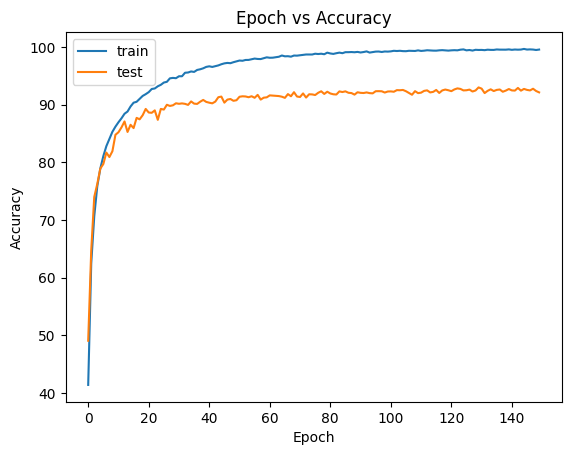

In [ ]:
# Plot the accuracy
plt.plot(arr_train_acc)
plt.plot(arr_test_acc)
plt.legend(["train","test"])
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

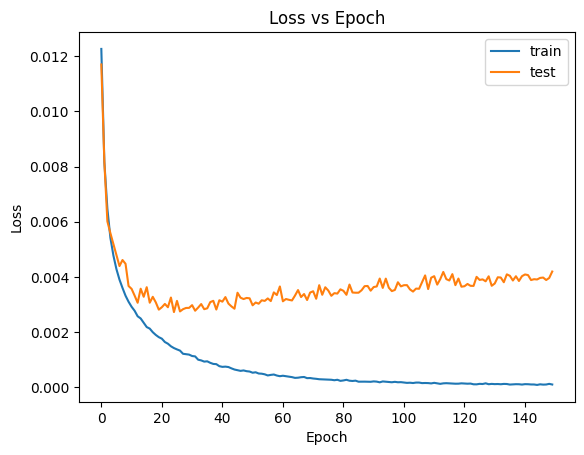

In [ ]:
# Plot the loss
plt.plot(train_loss_per_epoch)
plt.plot(arr_test)
plt.legend(["train","test"])
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Save the model
model.cpu()
model_scripted = torch.jit.script(model)
model_scripted.save('ResNet_lite.pt')
print("Saved Model")

Saved Model


In [ ]:
# Function to get prediction labels and probablities
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  probs = []

  with torch.no_grad():
    for (img,lbl) in iterator:
      img = img.to(device)
      outputs = model(img)
      y_prob = F.softmax(outputs, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      labels.append(lbl.cpu())
      probs.append(y_prob.cpu())

  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return labels, probs

# Get our model predictions
model.to('cuda')
labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

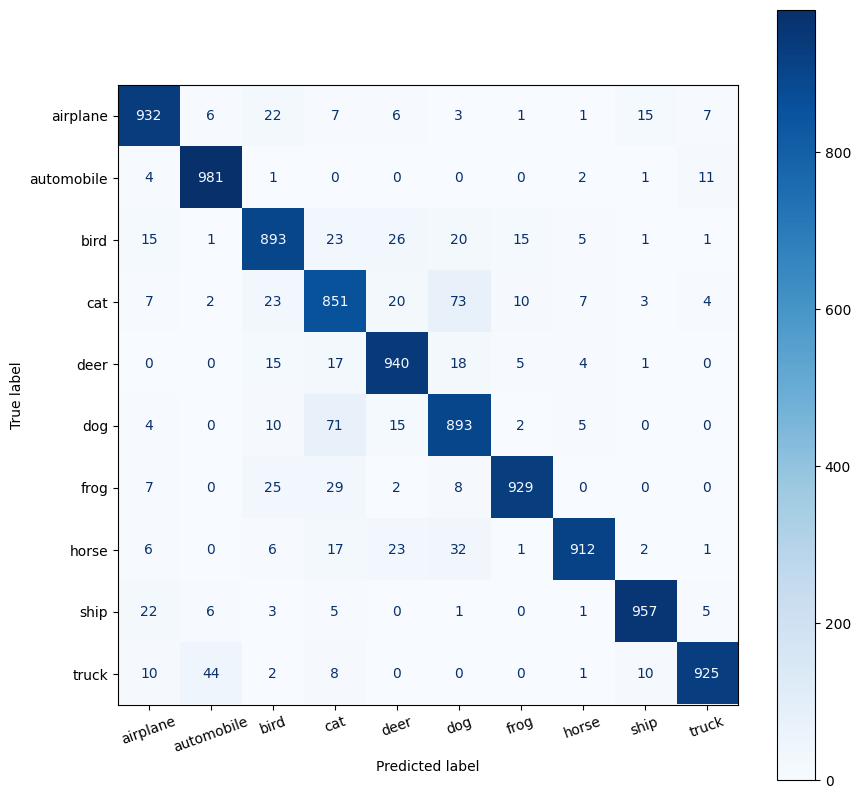

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(labels, pred_labels, classes):
  fig = plt.figure(figsize = (10, 10));
  ax = fig.add_subplot(1, 1, 1);
  cm = confusion_matrix(labels, pred_labels);
  cm = ConfusionMatrixDisplay(cm, display_labels = classes);
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 20)

# Plot the confusion matrix for our model
plot_confusion_matrix(labels, pred_labels, classes)